<a href="https://www.kaggle.com/code/maryamalimohammed/image-classification-draft1?scriptVersionId=194387184" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# importing what we need
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
import matplotlib.image as mpimg
import cv2
from PIL import Image
from io import BytesIO
import os
import random
from scipy.stats import pointbiserialr
from  sklearn.preprocessing import OrdinalEncoder
import torchvision.transforms as transforms
import h5py
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv")
path_list = [f"/kaggle/input/isic-2024-challenge/train-image/image/{id}.jpg" for id in df.isic_id]

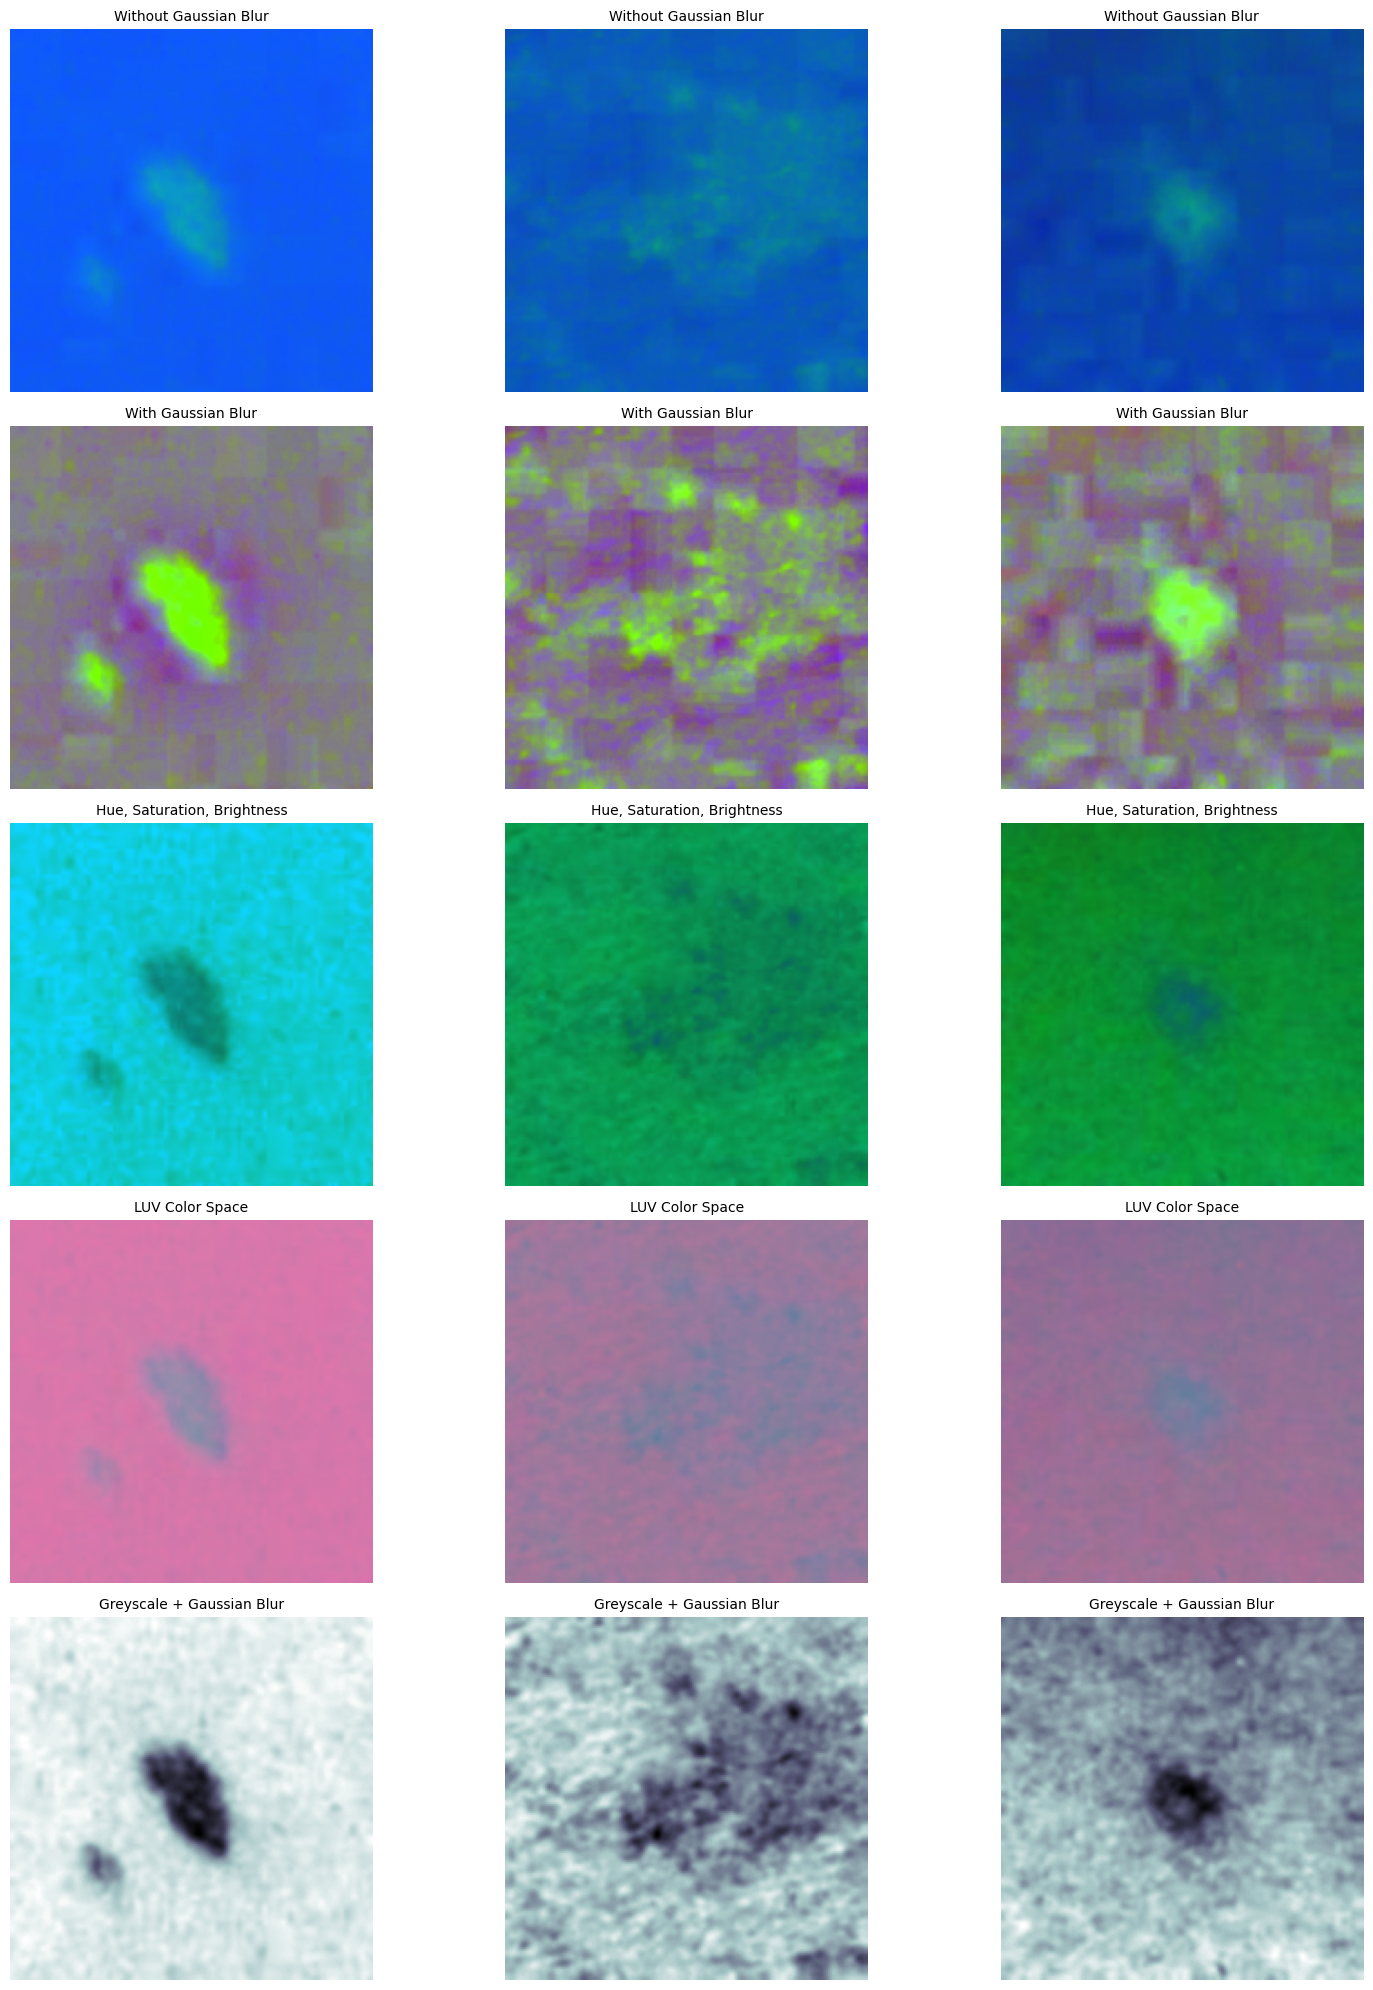

In [3]:
def apply_transformations(image_paths):
    selected_images = np.random.choice(image_paths, 3, replace=False)

    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(16, 20))
    methods = ["Without Gaussian Blur", "With Gaussian Blur", "Hue, Saturation, Brightness", "LUV Color Space", "Greyscale + Gaussian Blur"]
    
    for index, method in enumerate(methods):
        for i, path in enumerate(selected_images):
            image = cv2.imread(path)

            if method == "Without Gaussian Blur":
                transformed_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
                transformed_image = cv2.resize(transformed_image, (200, 200))

            elif method == "With Gaussian Blur":
                transformed_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
                transformed_image = cv2.resize(transformed_image, (200, 200))
                transformed_image = cv2.addWeighted(transformed_image, 4, cv2.GaussianBlur(transformed_image, (0, 0), 256/10), -4, 128)

            elif method == "Hue, Saturation, Brightness":
                transformed_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
                transformed_image = cv2.resize(transformed_image, (200, 200))

            elif method == "LUV Color Space":
                transformed_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
                transformed_image = cv2.resize(transformed_image, (200, 200))

            elif method == "Greyscale + Gaussian Blur":
                transformed_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                transformed_image = cv2.resize(transformed_image, (200, 200))
                transformed_image = cv2.GaussianBlur(transformed_image, (5, 5), 0)

            axes[index, i].imshow(transformed_image, cmap=plt.cm.bone if len(transformed_image.shape) == 2 else None)
            axes[index, i].axis('off')
            axes[index, i].set_title(method, fontsize=10)

    plt.tight_layout()
    plt.show()

apply_transformations(path_list)


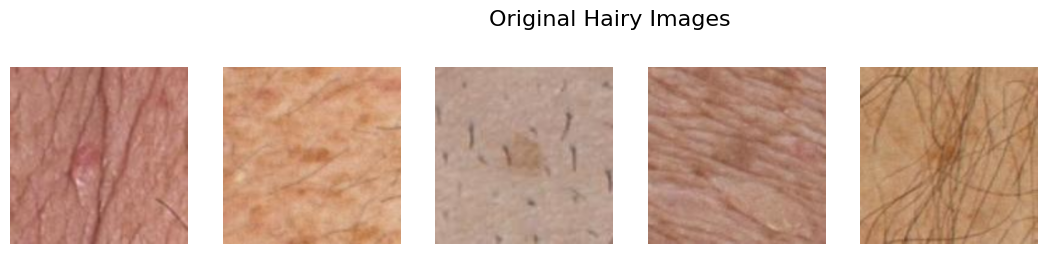

In [4]:
image_hair = np.array(path_list)[[1, 2, 8, 11, 13, 17]]

def hair_remove(image):
    # convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1,(17,17))

    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

    # apply thresholding to blackhat
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)

    # inpaint with original image and threshold image
    final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)

    return final_image

# Show the Augmented Images
plt.figure(figsize=(16,3))
plt.suptitle("Original Hairy Images", fontsize = 16)
    
for k, path in enumerate(image_hair[:5]):
    image = mpimg.imread(path)
    image = cv2.resize(image,(300, 300))
        
    plt.subplot(1, 6, k+1)
    plt.imshow(image)
    plt.axis('off')

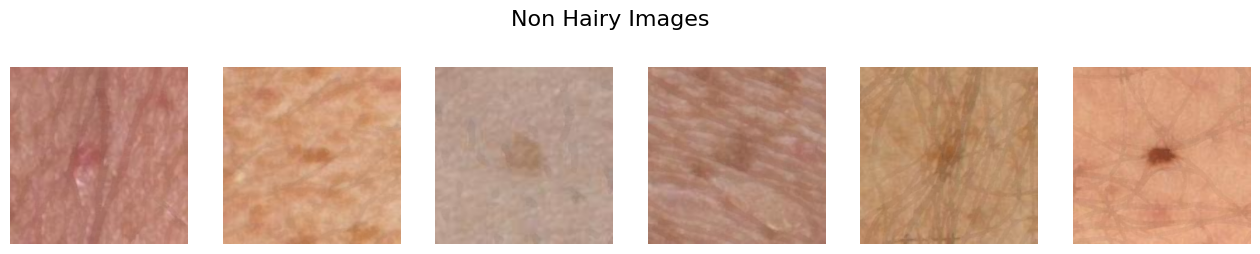

In [5]:
# Show the sample
plt.figure(figsize=(16,3))
plt.suptitle("Non Hairy Images", fontsize = 16)
    
for k, path in enumerate(image_hair):
    image = mpimg.imread(path)
    image = cv2.resize(image,(300, 300))
    image = hair_remove(image)
        
    plt.subplot(1, 6, k+1)
    plt.imshow(image)
    plt.axis('off')

In [6]:
def seed_everything(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [7]:
# Define your dataset and transforms
transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
 
class FlowerDataset(Dataset):
    def __init__(self, df, transform=None, test_mode=False):
        self.df = df.reset_index(drop=True)
        self.path = self.df.iloc[:, 0]
        self.test_mode = test_mode
        if not self.test_mode:
            self.target = self.df.iloc[:, 1]
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(self.path[index])
        if self.transform is not None:
            img = self.transform(img)
        if not self.test_mode:
            target = self.target[index]
            return img, target
        else:
            return img

    def __len__(self):
        return len(self.path)

In [8]:
# Data preparation
df["path_list"] = pd.Series(path_list)
melanoma = df[df["target"] == 1]
nonmelanoma = df[df["target"] == 0].sample(len(melanoma) * 3)
Data = pd.concat([melanoma, nonmelanoma], axis=0).reset_index(drop=True)
df = Data[["path_list", "target"]]

<Axes: xlabel='target', ylabel='count'>

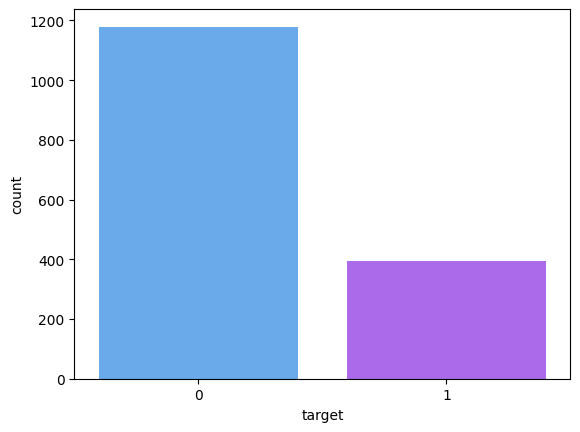

In [9]:
sns.countplot(x = Data["target"], palette = "cool")

In [10]:
# Label encoding
label_encoder = LabelEncoder()
df.iloc[:, 1] = label_encoder.fit_transform(df.iloc[:, 1])
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Clase: {class_name}, Etiqueta: {i}")

# Train/Validation/Test split
Train, Test = tts(df, test_size=0.01 / 2, stratify=df.iloc[:, 1])
Train, Valid = tts(Train, test_size=0.1, stratify=Train.iloc[:, 1])

print(f"Train Shape is: {Train.shape}")
print(f"Valid Shape is: {Valid.shape}")
print(f"Test Shape is: {Test.shape}")
print(f"Validation and Test Len is {(Valid.shape[0] + Test.shape[0]) / df.shape[0]:.2%}")

# Create DataLoader instances
train_ds = FlowerDataset(Train, transform)
valid_ds = FlowerDataset(Valid, transform_test)
test_ds = FlowerDataset(Test, transform_test)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

Clase: 0, Etiqueta: 0
Clase: 1, Etiqueta: 1
Train Shape is: (1407, 2)
Valid Shape is: (157, 2)
Test Shape is: (8, 2)
Validation and Test Len is 10.50%


In [11]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_targets = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device).float(), y.to(device).long()
            outputs = model(X)
            _, preds = torch.max(outputs.data, 1)
            
            all_targets.extend(y.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_scores.extend(outputs.cpu().numpy())

    all_targets = np.array(all_targets)
    all_preds = np.array(all_preds)
    all_scores = np.array(all_scores)

    accuracy = np.mean(all_preds == all_targets)
    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    f1 = f1_score(all_targets, all_preds, average='weighted')
    
    # Assuming binary classification for ROC-AUC
    if len(np.unique(all_targets)) == 2:
        roc_auc = roc_auc_score(all_targets, all_scores[:, 1])
    else:
        roc_auc = np.nan  # ROC-AUC not defined for multi-class

    return accuracy * 100, precision * 100, recall* 100, f1* 100, roc_auc* 100  # Convert accuracy to percentage

In [12]:
def train_and_evaluate(model, optimizer, criterion, train_dl, valid_dl, epochs, device):
    result = []
    val_res = []
    best_roc_auc = 0.0
    best_epoch = 0
    best_metrics = None

    for e in range(epochs):
        print(f"Training Epoch: {e + 1}")
        model.train()
        total_loss = 0
        total = 0
        correct = 0

        for X_train, y_train in train_dl:
            X_train, y_train = X_train.to(device).float(), y_train.to(device).long()

            optimizer.zero_grad()
            y_pred = model(X_train)

            # Handle InceptionV3 output
            if isinstance(y_pred, torchvision.models.inception.InceptionOutputs):
                y_pred = y_pred.logits

            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(y_pred.data, 1)
            total += y_train.size(0)
            correct += (predicted == y_train).sum().item()

        acc_train = 100 * correct / total
        accuracy, precision, recall, f1, roc_auc = evaluate_model(model, valid_dl, device)

        # Update the best model based on AUC-ROC score
        if roc_auc > best_roc_auc:
            best_roc_auc = roc_auc
            best_epoch = e + 1
            best_metrics = (accuracy, precision, recall, f1, roc_auc)

        print(f'Epoch: [{e+1}/{epochs}], Loss: {total_loss / total:.4f}, Train Acc: {acc_train:.2f}, Val Acc: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}, ROC-AUC: {roc_auc:.2f}')
        result.append(acc_train)
        val_res.append((accuracy, precision, recall, f1, roc_auc))

    # Save results to files
    np.savetxt('result.csv', np.array(result), fmt='%.2f', delimiter=',')
    np.savetxt('val_result.csv', np.array([x[0] for x in val_res]), fmt='%.2f', delimiter=',')  # Accuracy
    np.savetxt('val_precision.csv', np.array([x[1] for x in val_res]), fmt='%.2f', delimiter=',')  # Precision
    np.savetxt('val_recall.csv', np.array([x[2] for x in val_res]), fmt='%.2f', delimiter=',')  # Recall
    np.savetxt('val_f1.csv', np.array([x[3] for x in val_res]), fmt='%.2f', delimiter=',')  # F1 Score
    np.savetxt('val_roc_auc.csv', np.array([x[4] for x in val_res]), fmt='%.2f', delimiter=',')  # ROC-AUC

    # Plot metrics
    plt.figure()
    plt.plot(range(1, len(result) + 1), result, color='blue', label='Train Accuracy')
    plt.plot(range(1, len(val_res) + 1), [x[0] for x in val_res], color='red', label='Validation Accuracy')
    plt.plot(range(1, len(val_res) + 1), [x[1] for x in val_res], color='green', label='Validation Precision')
    plt.plot(range(1, len(val_res) + 1), [x[2] for x in val_res], color='orange', label='Validation Recall')
    plt.plot(range(1, len(val_res) + 1), [x[3] for x in val_res], color='purple', label='Validation F1 Score')
    plt.plot(range(1, len(val_res) + 1), [x[4] for x in val_res], color='brown', label='Validation ROC-AUC')
    plt.legend()
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.title('Metrics Over Epochs', fontsize=16)
    plt.savefig('metrics_plot.png')
    plt.show()

    # Return the best epoch and metrics
    return best_epoch, best_metrics

In [13]:
import torchvision
import torchvision.transforms as transforms

**ResNet50 + Pytorch**

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 156MB/s]


Training Epoch: 1
Epoch: [1/20], Loss: 0.0179, Train Acc: 72.64, Val Acc: 75.80, Precision: 81.69, Recall: 75.80, F1 Score: 65.98, ROC-AUC: 70.75
Training Epoch: 2
Epoch: [2/20], Loss: 0.0167, Train Acc: 76.69, Val Acc: 75.80, Precision: 71.82, Recall: 75.80, F1 Score: 68.82, ROC-AUC: 76.97
Training Epoch: 3
Epoch: [3/20], Loss: 0.0142, Train Acc: 80.10, Val Acc: 77.71, Precision: 75.65, Recall: 77.71, F1 Score: 72.95, ROC-AUC: 78.31
Training Epoch: 4
Epoch: [4/20], Loss: 0.0134, Train Acc: 81.02, Val Acc: 80.25, Precision: 78.83, Recall: 80.25, F1 Score: 77.81, ROC-AUC: 79.16
Training Epoch: 5
Epoch: [5/20], Loss: 0.0129, Train Acc: 82.30, Val Acc: 76.43, Precision: 73.19, Recall: 76.43, F1 Score: 70.75, ROC-AUC: 78.99
Training Epoch: 6
Epoch: [6/20], Loss: 0.0142, Train Acc: 80.67, Val Acc: 78.34, Precision: 76.26, Recall: 78.34, F1 Score: 76.24, ROC-AUC: 78.73
Training Epoch: 7
Epoch: [7/20], Loss: 0.0121, Train Acc: 83.94, Val Acc: 82.17, Precision: 81.42, Recall: 82.17, F1 Score: 

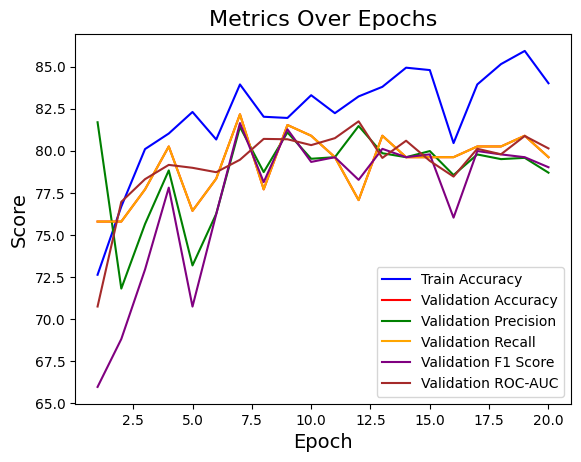

In [14]:
# Define and prepare the model
Resnet50 = models.resnet50(pretrained=True)
for param in Resnet50.parameters():
    param.requires_grad = False
features = Resnet50.fc.in_features
Resnet50.fc = nn.Linear(features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Resnet50 = Resnet50.to(device)

# Define optimizer and criterion
optimizer = optim.SGD(Resnet50.parameters(), lr=0.003, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Train and evaluate
best_epoch, best_metrics = train_and_evaluate(Resnet50, optimizer, criterion, train_dl, valid_dl, epochs=20, device=device)

In [15]:
print(f"Best Epoch: {best_epoch}")
print(f"Best Metrics - Accuracy: {best_metrics[0]:.2f}, Precision: {best_metrics[1]:.2f}, Recall: {best_metrics[2]:.2f}, F1 Score: {best_metrics[3]:.2f}, ROC-AUC: {best_metrics[4]:.2f}")

Best Epoch: 12
Best Metrics - Accuracy: 77.07, Precision: 81.47, Recall: 77.07, F1 Score: 78.27, ROC-AUC: 81.75


**InceptionV3 with Pytorch**

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 140MB/s] 


Training Epoch: 1
Epoch: [1/20], Loss: 0.0180, Train Acc: 73.99, Val Acc: 75.80, Precision: 81.69, Recall: 75.80, F1 Score: 65.98, ROC-AUC: 63.30
Training Epoch: 2
Epoch: [2/20], Loss: 0.0163, Train Acc: 75.55, Val Acc: 77.07, Precision: 75.87, Recall: 77.07, F1 Score: 70.46, ROC-AUC: 65.08
Training Epoch: 3
Epoch: [3/20], Loss: 0.0153, Train Acc: 77.19, Val Acc: 75.80, Precision: 71.82, Recall: 75.80, F1 Score: 68.82, ROC-AUC: 66.12
Training Epoch: 4
Epoch: [4/20], Loss: 0.0152, Train Acc: 78.75, Val Acc: 76.43, Precision: 73.06, Recall: 76.43, F1 Score: 71.40, ROC-AUC: 66.80
Training Epoch: 5
Epoch: [5/20], Loss: 0.0151, Train Acc: 78.32, Val Acc: 75.16, Precision: 69.40, Recall: 75.16, F1 Score: 66.65, ROC-AUC: 65.99
Training Epoch: 6
Epoch: [6/20], Loss: 0.0147, Train Acc: 78.32, Val Acc: 73.25, Precision: 68.21, Recall: 73.25, F1 Score: 69.13, ROC-AUC: 64.58
Training Epoch: 7
Epoch: [7/20], Loss: 0.0150, Train Acc: 78.04, Val Acc: 75.16, Precision: 69.92, Recall: 75.16, F1 Score: 

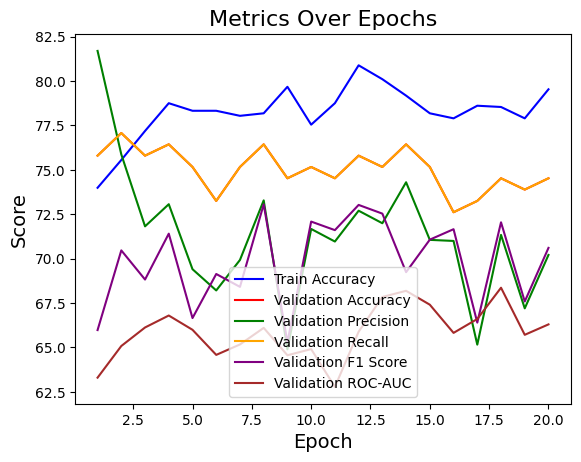

In [16]:
# Define and prepare the model
Inception = models.inception_v3(pretrained=True)
for param in Inception.parameters():
    param.requires_grad = False
features = Inception.fc.in_features
Inception.fc = nn.Linear(features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Inception = Inception.to(device)

# Define optimizer and criterion
optimizer = optim.SGD(Inception.parameters(), lr=0.003, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Train and evaluate
best_epoch, best_metrics = train_and_evaluate(Inception, optimizer, criterion, train_dl, valid_dl, epochs=20, device=device)

In [17]:
print(f"Best Epoch: {best_epoch}")
print(f"Best Metrics - Accuracy: {best_metrics[0]:.2f}, Precision: {best_metrics[1]:.2f}, Recall: {best_metrics[2]:.2f}, F1 Score: {best_metrics[3]:.2f}, ROC-AUC: {best_metrics[4]:.2f}")

Best Epoch: 18
Best Metrics - Accuracy: 74.52, Precision: 71.33, Recall: 74.52, F1 Score: 72.04, ROC-AUC: 68.36


**AlexNet with Pytorch**

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 161MB/s]


Training Epoch: 1
Epoch: [1/20], Loss: 0.0213, Train Acc: 73.28, Val Acc: 74.52, Precision: 74.09, Recall: 74.52, F1 Score: 74.29, ROC-AUC: 76.08
Training Epoch: 2
Epoch: [2/20], Loss: 0.0175, Train Acc: 77.83, Val Acc: 67.52, Precision: 78.32, Recall: 67.52, F1 Score: 69.72, ROC-AUC: 76.84
Training Epoch: 3
Epoch: [3/20], Loss: 0.0178, Train Acc: 78.04, Val Acc: 80.25, Precision: 79.50, Recall: 80.25, F1 Score: 79.78, ROC-AUC: 78.21
Training Epoch: 4
Epoch: [4/20], Loss: 0.0168, Train Acc: 78.46, Val Acc: 77.07, Precision: 74.96, Recall: 77.07, F1 Score: 71.20, ROC-AUC: 76.88
Training Epoch: 5
Epoch: [5/20], Loss: 0.0130, Train Acc: 82.73, Val Acc: 77.71, Precision: 77.52, Recall: 77.71, F1 Score: 77.61, ROC-AUC: 76.38
Training Epoch: 6
Epoch: [6/20], Loss: 0.0147, Train Acc: 79.96, Val Acc: 78.34, Precision: 76.20, Recall: 78.34, F1 Score: 75.01, ROC-AUC: 76.73
Training Epoch: 7
Epoch: [7/20], Loss: 0.0157, Train Acc: 79.18, Val Acc: 77.71, Precision: 76.82, Recall: 77.71, F1 Score: 

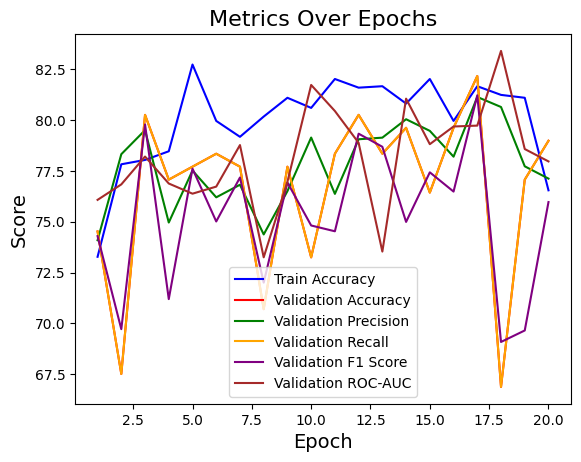

In [18]:
# Define and prepare the model
Alexnet = models.alexnet(pretrained=True)
for param in Alexnet.parameters():
    param.requires_grad = False
features = Alexnet.classifier[6].in_features
Alexnet.classifier[6] = nn.Linear(features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Alexnet = Alexnet.to(device)

# Define optimizer and criterion
optimizer = optim.SGD(Alexnet.parameters(), lr=0.003, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Train and evaluate
best_epoch, best_metrics = train_and_evaluate(Alexnet, optimizer, criterion, train_dl, valid_dl, epochs=20, device=device)

In [19]:
print(f"Best Epoch: {best_epoch}")
print(f"Best Metrics - Accuracy: {best_metrics[0]:.2f}, Precision: {best_metrics[1]:.2f}, Recall: {best_metrics[2]:.2f}, F1 Score: {best_metrics[3]:.2f}, ROC-AUC: {best_metrics[4]:.2f}")

Best Epoch: 18
Best Metrics - Accuracy: 66.88, Precision: 80.64, Recall: 66.88, F1 Score: 69.09, ROC-AUC: 83.40


**VGG19 with Pytorch**

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 170MB/s]


Training Epoch: 1
Epoch: [1/20], Loss: 0.0171, Train Acc: 74.63, Val Acc: 74.52, Precision: 67.77, Recall: 74.52, F1 Score: 67.18, ROC-AUC: 72.53
Training Epoch: 2
Epoch: [2/20], Loss: 0.0155, Train Acc: 77.68, Val Acc: 76.43, Precision: 73.28, Recall: 76.43, F1 Score: 73.05, ROC-AUC: 76.12
Training Epoch: 3
Epoch: [3/20], Loss: 0.0157, Train Acc: 77.26, Val Acc: 75.16, Precision: 69.92, Recall: 75.16, F1 Score: 68.41, ROC-AUC: 76.60
Training Epoch: 4
Epoch: [4/20], Loss: 0.0150, Train Acc: 77.40, Val Acc: 76.43, Precision: 73.92, Recall: 76.43, F1 Score: 74.33, ROC-AUC: 77.03
Training Epoch: 5
Epoch: [5/20], Loss: 0.0149, Train Acc: 78.89, Val Acc: 74.52, Precision: 70.96, Recall: 74.52, F1 Score: 71.60, ROC-AUC: 77.57
Training Epoch: 6
Epoch: [6/20], Loss: 0.0149, Train Acc: 78.54, Val Acc: 75.16, Precision: 70.47, Recall: 75.16, F1 Score: 69.86, ROC-AUC: 76.18
Training Epoch: 7
Epoch: [7/20], Loss: 0.0149, Train Acc: 78.46, Val Acc: 76.43, Precision: 75.13, Recall: 76.43, F1 Score: 

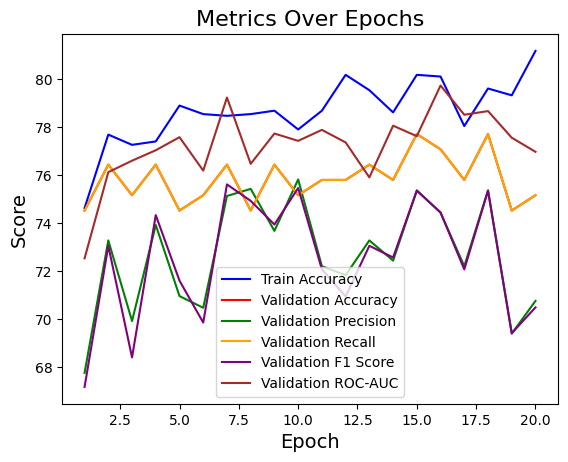

In [20]:
# Define and prepare the model
VGG = models.vgg19(pretrained=True)
for param in VGG.parameters():
    param.requires_grad = False
features = VGG.classifier[6].in_features
VGG.classifier[6] = nn.Linear(features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
VGG = VGG.to(device)

# Define optimizer and criterion
optimizer = optim.SGD(VGG.parameters(), lr=0.003, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Train and evaluate
best_epoch, best_metrics = train_and_evaluate(VGG, optimizer, criterion, train_dl, valid_dl, epochs=20, device=device)

In [21]:
print(f"Best Epoch: {best_epoch}")
print(f"Best Metrics - Accuracy: {best_metrics[0]:.2f}, Precision: {best_metrics[1]:.2f}, Recall: {best_metrics[2]:.2f}, F1 Score: {best_metrics[3]:.2f}, ROC-AUC: {best_metrics[4]:.2f}")

Best Epoch: 16
Best Metrics - Accuracy: 77.07, Precision: 74.43, Recall: 77.07, F1 Score: 74.44, ROC-AUC: 79.73


**VGG19 with Batch Normalization + Pytorch**

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:03<00:00, 159MB/s]


Training Epoch: 1
Epoch: [1/20], Loss: 0.0169, Train Acc: 74.84, Val Acc: 78.34, Precision: 76.20, Recall: 78.34, F1 Score: 75.01, ROC-AUC: 71.19
Training Epoch: 2
Epoch: [2/20], Loss: 0.0152, Train Acc: 78.25, Val Acc: 78.98, Precision: 77.31, Recall: 78.98, F1 Score: 75.52, ROC-AUC: 71.90
Training Epoch: 3
Epoch: [3/20], Loss: 0.0149, Train Acc: 79.67, Val Acc: 76.43, Precision: 73.92, Recall: 76.43, F1 Score: 74.33, ROC-AUC: 70.86
Training Epoch: 4
Epoch: [4/20], Loss: 0.0146, Train Acc: 79.89, Val Acc: 77.07, Precision: 75.36, Recall: 77.07, F1 Score: 75.85, ROC-AUC: 72.56
Training Epoch: 5
Epoch: [5/20], Loss: 0.0147, Train Acc: 79.39, Val Acc: 77.71, Precision: 75.52, Recall: 77.71, F1 Score: 75.72, ROC-AUC: 75.95
Training Epoch: 6
Epoch: [6/20], Loss: 0.0140, Train Acc: 81.31, Val Acc: 77.07, Precision: 74.27, Recall: 77.07, F1 Score: 72.48, ROC-AUC: 71.82
Training Epoch: 7
Epoch: [7/20], Loss: 0.0142, Train Acc: 78.89, Val Acc: 75.16, Precision: 74.14, Recall: 75.16, F1 Score: 

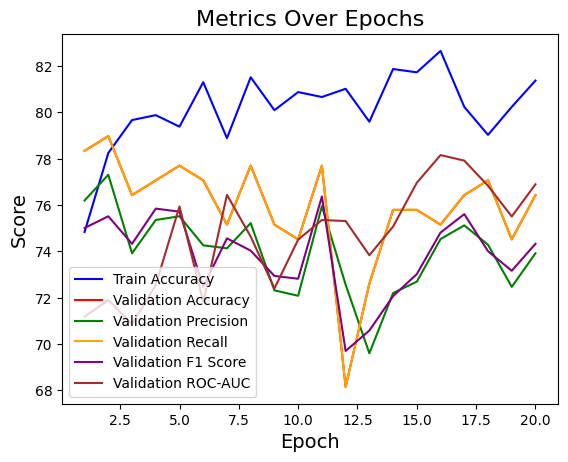

In [22]:
# Define and prepare the model
VGG_bn = models.vgg19_bn(pretrained=True)
for param in VGG_bn.parameters():
    param.requires_grad = False
features = VGG_bn.classifier[6].in_features
VGG_bn.classifier[6] = nn.Linear(features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
VGG_bn = VGG_bn.to(device)

# Define optimizer and criterion
optimizer = optim.SGD(VGG_bn.parameters(), lr=0.003, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Train and evaluate
best_epoch, best_metrics = train_and_evaluate(VGG_bn, optimizer, criterion, train_dl, valid_dl, epochs=20, device=device)

In [23]:
print(f"Best Epoch: {best_epoch}")
print(f"Best Metrics - Accuracy: {best_metrics[0]:.2f}, Precision: {best_metrics[1]:.2f}, Recall: {best_metrics[2]:.2f}, F1 Score: {best_metrics[3]:.2f}, ROC-AUC: {best_metrics[4]:.2f}")

Best Epoch: 16
Best Metrics - Accuracy: 75.16, Precision: 74.54, Recall: 75.16, F1 Score: 74.82, ROC-AUC: 78.16


**EfficientNet**

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 104MB/s]


Training Epoch: 1
Epoch: [1/20], Loss: 0.0175, Train Acc: 73.13, Val Acc: 75.16, Precision: 71.36, Recall: 75.16, F1 Score: 71.60, ROC-AUC: 66.80
Training Epoch: 2
Epoch: [2/20], Loss: 0.0148, Train Acc: 79.25, Val Acc: 76.43, Precision: 74.80, Recall: 76.43, F1 Score: 75.33, ROC-AUC: 72.84
Training Epoch: 3
Epoch: [3/20], Loss: 0.0138, Train Acc: 81.45, Val Acc: 77.71, Precision: 75.95, Recall: 77.71, F1 Score: 76.37, ROC-AUC: 75.08
Training Epoch: 4
Epoch: [4/20], Loss: 0.0131, Train Acc: 82.23, Val Acc: 78.98, Precision: 77.25, Recall: 78.98, F1 Score: 77.43, ROC-AUC: 76.77
Training Epoch: 5
Epoch: [5/20], Loss: 0.0129, Train Acc: 82.37, Val Acc: 78.98, Precision: 77.12, Recall: 78.98, F1 Score: 77.11, ROC-AUC: 77.90
Training Epoch: 6
Epoch: [6/20], Loss: 0.0125, Train Acc: 82.87, Val Acc: 77.07, Precision: 75.98, Recall: 77.07, F1 Score: 76.40, ROC-AUC: 79.29
Training Epoch: 7
Epoch: [7/20], Loss: 0.0122, Train Acc: 83.44, Val Acc: 77.71, Precision: 75.52, Recall: 77.71, F1 Score: 

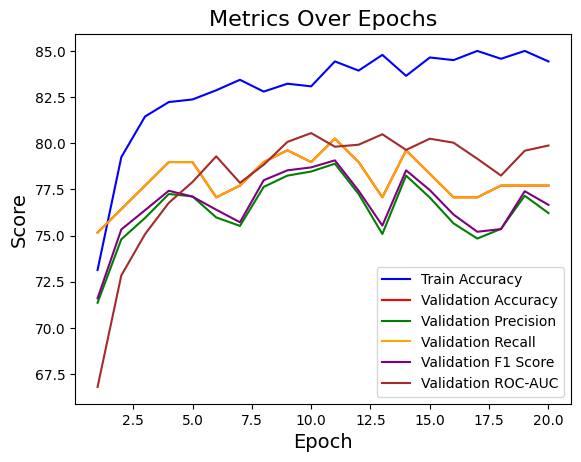

In [24]:
# Define and prepare the model
EfficientNet = models.efficientnet_b0(pretrained=True)
for param in EfficientNet.parameters():
    param.requires_grad = False
features = EfficientNet.classifier[1].in_features
EfficientNet.classifier[1] = nn.Linear(features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EfficientNet = EfficientNet.to(device)

# Define optimizer and criterion
optimizer = optim.SGD(EfficientNet.parameters(), lr=0.003, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Train and evaluate
best_epoch, best_metrics = train_and_evaluate(EfficientNet, optimizer, criterion, train_dl, valid_dl, epochs=20, device=device)

In [25]:
print(f"Best Epoch: {best_epoch}, Best Metrics: {best_metrics}")

Best Epoch: 10, Best Metrics: (78.98089171974523, 78.46896878454494, 78.98089171974523, 78.69242864376517, 80.55193394176445)


Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 161MB/s]


Training Epoch: 1
Epoch: [1/20], Loss: 0.0195, Train Acc: 67.31, Val Acc: 75.80, Precision: 81.69, Recall: 75.80, F1 Score: 65.98, ROC-AUC: 64.75
Training Epoch: 2
Epoch: [2/20], Loss: 0.0165, Train Acc: 76.90, Val Acc: 76.43, Precision: 82.06, Recall: 76.43, F1 Score: 67.40, ROC-AUC: 67.36
Training Epoch: 3
Epoch: [3/20], Loss: 0.0151, Train Acc: 79.39, Val Acc: 76.43, Precision: 74.30, Recall: 76.43, F1 Score: 69.24, ROC-AUC: 70.30
Training Epoch: 4
Epoch: [4/20], Loss: 0.0141, Train Acc: 79.96, Val Acc: 77.07, Precision: 74.49, Recall: 77.07, F1 Score: 71.87, ROC-AUC: 72.43
Training Epoch: 5
Epoch: [5/20], Loss: 0.0141, Train Acc: 79.53, Val Acc: 75.80, Precision: 71.83, Recall: 75.80, F1 Score: 70.95, ROC-AUC: 74.58
Training Epoch: 6
Epoch: [6/20], Loss: 0.0134, Train Acc: 80.88, Val Acc: 78.34, Precision: 76.37, Recall: 78.34, F1 Score: 74.53, ROC-AUC: 75.62
Training Epoch: 7
Epoch: [7/20], Loss: 0.0135, Train Acc: 81.17, Val Acc: 77.07, Precision: 74.18, Recall: 77.07, F1 Score: 

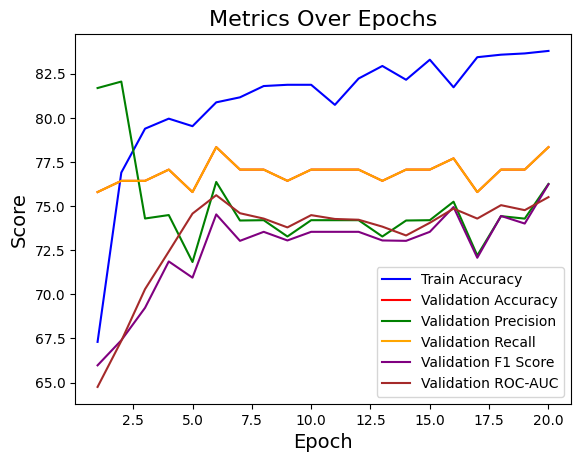

In [26]:
# Define and prepare the model
EfficientNet_b7 = models.efficientnet_b7(pretrained=True)
for param in EfficientNet_b7.parameters():
    param.requires_grad = False
features = EfficientNet_b7.classifier[1].in_features
EfficientNet_b7.classifier[1] = nn.Linear(features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EfficientNet_b7 = EfficientNet_b7.to(device)

# Define optimizer and criterion
optimizer = optim.SGD(EfficientNet_b7.parameters(), lr=0.003, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Train and evaluate
best_epoch, best_metrics = train_and_evaluate(EfficientNet_b7, optimizer, criterion, train_dl, valid_dl, epochs=20, device=device)

In [27]:
print(f"Best Epoch: {best_epoch}, Best Metrics: {best_metrics}")

Best Epoch: 6, Best Metrics: (78.343949044586, 76.37032385395173, 78.343949044586, 74.53100332081223, 75.61929595827901)
